Filtering


/Users/shamit/Documents/Projects/RA/cobas/cobas/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/shamit/Documents/Projects/RA/cobas/cobas/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/shamit/Documents/Projects/RA/cobas/cobas/venv/lib/python3.9/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer


=== Video-Level Results ===
empty_3 (Majority) -> True: Empty  Pred: Empty
full_3 (Majority) -> True: Full  Pred: Full
full_43 (Majority) -> True: Full  Pred: Full

=== Test Video-Level Accuracy: 100.00% ===


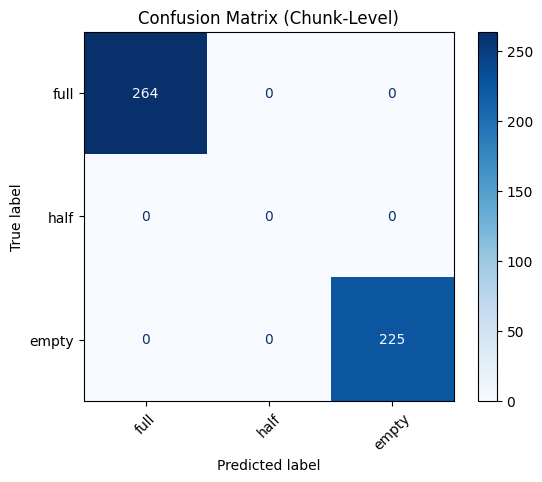

In [3]:
import os, glob, subprocess
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import torchaudio
import torchaudio.transforms as T
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# SETTINGS (match training)
AUDIO_DIR = "audio_segments/battery/test"     
IMAGE_DIR = "recorded_images/battery/test"     
TEST_DIR  = "test_videos/exxp"                 

SAMPLE_RATE   = 48000        # <- training used 48k end-to-end
N_MELS        = 64
CHUNK_SECONDS = 2
BATCH_SIZE    = 1            # test per-segment
MODEL_PATH    = "multimodal_model_battery_v3.pth"
DEVICE        = "cuda" if torch.cuda.is_available() else "cpu"

label_map = {"full": 0, "half": 1, "empty": 2}
LABELS = {v: k.capitalize() for k, v in label_map.items()}

os.makedirs(AUDIO_DIR, exist_ok=True)
os.makedirs(IMAGE_DIR, exist_ok=True)

# PREPROCESSING: video -> 2s audio + mid-frames
def extract_audio(video_path, audio_out, sample_rate=SAMPLE_RATE):
    cmd = ["ffmpeg", "-y", "-i", video_path, "-ar", str(sample_rate), "-ac", "1", audio_out]
    subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, check=True)

def extract_frame(video_path, image_out, timestamp=2.0):
    cmd = ["ffmpeg", "-y", "-i", video_path, "-ss", f"{timestamp:.3f}", "-vframes", "1", image_out]
    subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL, check=True)

def split_audio_and_frames(video_path, audio_out_dir, image_out_dir,
                           chunk_sec=CHUNK_SECONDS, sample_rate=SAMPLE_RATE):
    base = os.path.splitext(os.path.basename(video_path))[0]   # e.g., full_8
    # full audio
    audio_tmp = os.path.join(audio_out_dir, base + ".wav")
    extract_audio(video_path, audio_tmp, sample_rate=sample_rate)

    # split to 2s chunks + mid-frames
    waveform, sr = torchaudio.load(audio_tmp)
    if sr != sample_rate:
        waveform = torchaudio.functional.resample(waveform, sr, sample_rate)
        sr = sample_rate
    total_samples = waveform.shape[1]
    chunk_samples = int(chunk_sec * sr)
    n_chunks = total_samples // chunk_samples

    for i in range(n_chunks):
        start = i * chunk_samples
        end   = start + chunk_samples
        seg   = waveform[:, start:end]
        seg_name = f"{base}_seg{i}.wav"
        seg_path = os.path.join(audio_out_dir, seg_name)
        torchaudio.save(seg_path, seg, sr)

        ts = (i * chunk_sec) + (chunk_sec / 2.0)
        frame_path = os.path.join(image_out_dir, f"{base}_frame{i}.jpg")
        extract_frame(video_path, frame_path, timestamp=ts)

    print(f"[INFO] Processed {base} → {n_chunks} segments")

def prepare_dataset(raw_videos, audio_dir, image_dir):
    os.makedirs(audio_dir, exist_ok=True)
    os.makedirs(image_dir, exist_ok=True)
    video_files = []
    video_files.extend(glob.glob(os.path.join(raw_videos, "*.MOV")))
    video_files.extend(glob.glob(os.path.join(raw_videos, "*.mov")))
    video_files.extend(glob.glob(os.path.join(raw_videos, "*.mp4")))
    if not video_files:
        print(f"[WARN] No videos found in {raw_videos}")
    for vf in video_files:
        split_audio_and_frames(vf, audio_dir, image_dir)
    print(f"[INFO] Finished preprocessing {len(video_files)} videos.")

# IMAGE TRANSFORM
gray = transforms.Grayscale(num_output_channels=3)
transform_image = transforms.Compose([
    transforms.Resize((224,224)),
    gray,
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

SR        = SAMPLE_RATE
BAND_LO   = 12000
BAND_HI   = 18000
NFFT      = 2048
HOP       = 512
OVERSUB   = 1.2
QUIET_PCT = 0.20

def _istft(S: torch.Tensor, length: int) -> torch.Tensor:
    win = torch.hann_window(NFFT, device=S.device, dtype=torch.float32)
    try:
        y = torch.istft(S, n_fft=NFFT, hop_length=HOP, win_length=NFFT,
                        window=win, length=length, center=True)
    except (TypeError, RuntimeError):
        y = torch.istft(torch.view_as_real(S), n_fft=NFFT, hop_length=HOP, win_length=NFFT,
                        window=win, length=length, center=True)
    return y

def bandpass_chunk(waveform: torch.Tensor, sr: int) -> torch.Tensor:
    if waveform.dim() == 1: waveform = waveform.unsqueeze(0)
    x = waveform.squeeze(0).to(torch.float32)
    S = torch.stft(x, n_fft=NFFT, hop_length=HOP, win_length=NFFT,
                   window=torch.hann_window(NFFT, dtype=torch.float32),
                   return_complex=True, center=True)     # [F,T]
    freqs = np.fft.rfftfreq(NFFT, d=1.0/sr)
    lo = int(np.searchsorted(freqs, BAND_LO))
    hi = int(np.searchsorted(freqs, BAND_HI))
    lo = max(lo, 0); hi = min(hi, S.shape[0])
    mask = torch.zeros_like(S, dtype=torch.bool); mask[lo:hi, :] = True
    S_bp = torch.where(mask, S, torch.zeros_like(S))
    y = _istft(S_bp, length=x.numel())
    y = y - y.mean()
    y = torch.nan_to_num(y, nan=0.0, posinf=0.0, neginf=0.0)
    return y.unsqueeze(0)

def spectral_subtract_quiet_frames(waveform: torch.Tensor, sr: int) -> torch.Tensor:
    x = waveform.squeeze(0)
    Tlen = x.numel()
    S = torch.stft(x, n_fft=NFFT, hop_length=HOP, win_length=NFFT,
                   window=torch.hann_window(NFFT, dtype=torch.float32),
                   return_complex=True, center=True)
    Mag = S.abs(); Pow = Mag**2
    freqs = np.fft.rfftfreq(NFFT, d=1.0/sr)
    lo = int(np.searchsorted(freqs, BAND_LO)); hi = int(np.searchsorted(freqs, BAND_HI))
    lo = max(lo, 0); hi = min(hi, Mag.shape[0])
    band_pow = Pow[lo:hi].mean(dim=0)                   # [T_frames]
    T_frames = band_pow.numel()
    k = max(1, int(round(QUIET_PCT * T_frames)))
    _, idxs = torch.topk(-band_pow, k)                  # quietest frames
    quiet_mask = torch.zeros_like(band_pow, dtype=torch.bool)
    quiet_mask[idxs] = True
    Npsd = Pow[:, quiet_mask].mean(dim=1, keepdim=True) # noise PSD
    Pclean = torch.clamp(Pow - OVERSUB * Npsd, min=0.0)
    Mag_clean = torch.sqrt(Pclean + 1e-12)
    S_clean = Mag_clean * torch.exp(1j * S.angle())
    y = _istft(S_clean, length=Tlen)
    y = y - y.mean()
    y = torch.nan_to_num(y, nan=0.0, posinf=0.0, neginf=0.0)
    return y.unsqueeze(0)

def clean_chunk(waveform: torch.Tensor, sr: int) -> torch.Tensor:
    if waveform.dim() == 2 and waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)
    elif waveform.dim() == 1:
        waveform = waveform.unsqueeze(0)
    if sr != SR:
        waveform = torchaudio.functional.resample(waveform, sr, SR); sr = SR
    y_bp = bandpass_chunk(waveform, sr)
    y_cl = spectral_subtract_quiet_frames(y_bp, sr)
    return y_cl

class AudioImageDataset(Dataset):
    def __init__(self, audio_dir, image_dir, label_map, transform_image=None,
                 sample_rate=SAMPLE_RATE, n_mels=N_MELS, use_filters=True):
        self.audio_dir = audio_dir
        self.image_dir = image_dir
        self.label_map = label_map
        self.transform_image = transform_image
        self.sample_rate = sample_rate
        self.n_mels = n_mels
        self.use_filters = use_filters

        self.audio_files, self.labels, self.seg_ids, self.base_ids = [], [], [], []
        for file in os.listdir(audio_dir):
            if file.endswith(".wav") and "_seg" in file:
                frame_file = file.replace("seg", "frame").replace(".wav", ".jpg")
                if not os.path.exists(os.path.join(image_dir, frame_file)):
                    continue
                base_name = file.split("_seg")[0]                # e.g., full_8
                label_str = base_name.split("_")[0].lower()
                if label_str in label_map:
                    self.audio_files.append(file)                # keep seg filename
                    self.labels.append(label_map[label_str])
                    self.seg_ids.append(file)                    # segment id (for per-seg prints)
                    self.base_ids.append(base_name)              # base id for video-level vote

        self.mel = T.MelSpectrogram(sample_rate=self.sample_rate, n_fft=1024,
                                    hop_length=512, n_mels=self.n_mels)
        self.db = T.AmplitudeToDB()

    def __len__(self): return len(self.audio_files)

    def __getitem__(self, idx):
        audio_file = self.audio_files[idx]
        label      = self.labels[idx]
        seg_id     = self.seg_ids[idx]
        base_id    = self.base_ids[idx]

        # AUDIO
        a_path = os.path.join(self.audio_dir, audio_file)
        waveform, sr = torchaudio.load(a_path)   # 2s chunk
        if self.use_filters:
            waveform = clean_chunk(waveform, sr) # [1,T] @ 48k
        else:
            if sr != self.sample_rate:
                waveform = torchaudio.functional.resample(waveform, sr, self.sample_rate)

        spec = self.mel(waveform)
        spec = self.db(spec)
        spec = (spec - spec.mean()) / (spec.std() + 1e-6)
        spec = F.interpolate(spec.unsqueeze(0), size=(224,224), mode="bilinear", align_corners=False)
        spec = spec.mean(dim=1)  # [1,224,224]

        # IMAGE
        frame_file = audio_file.replace("seg", "frame").replace(".wav", ".jpg")
        img_path = os.path.join(self.image_dir, frame_file)
        img = Image.open(img_path).convert("RGB")
        if self.transform_image:
            img = self.transform_image(img)

        
        return spec, img, label, seg_id, base_id

class MultiModalResNet(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.audio_model = models.resnet18(pretrained=True)
        self.audio_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.audio_model.fc = nn.Identity()
        self.image_model = models.resnet18(pretrained=True)
        self.image_model.fc = nn.Identity()
        self.fc = nn.Linear(512*2, num_classes)

    def forward(self, audio, image):
        a = self.audio_model(audio)
        i = self.image_model(image)
        fused = torch.cat([a, i], dim=1)   # late fusion
        out = self.fc(fused)
        return out

# TEST FUNCTION
def test_model(model_path, audio_dir, image_dir, use_filters=True):
    # Dataset / loader
    test_dataset = AudioImageDataset(audio_dir=audio_dir, image_dir=image_dir,
                                     label_map=label_map, transform_image=transform_image,
                                     sample_rate=SAMPLE_RATE, n_mels=N_MELS,
                                     use_filters=use_filters)
    if len(test_dataset) == 0:
        print("[ERROR] No test segments found."); return 0.0, None
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Model
    model = MultiModalResNet(num_classes=len(label_map)).to(DEVICE)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model.eval()

    all_preds, all_labels, all_segids, all_baseids = [], [], [], []
    mismatched_segments = []

    with torch.no_grad():
        for audio, img, labels, seg_ids, base_ids in test_loader:
            audio, img = audio.to(DEVICE), img.to(DEVICE)
            outputs = model(audio, img)
            preds = outputs.argmax(1).cpu().tolist()

            all_preds.extend(preds)
            all_labels.extend(labels.tolist())
            all_segids.extend(seg_ids)
            all_baseids.extend(base_ids)

            # per-segment mismatches
            for p, t, seg in zip(preds, labels.tolist(), seg_ids):
                if p != t:
                    mismatched_segments.append(seg)
                    print(f"{seg} -> True: {LABELS[t]}  Pred: {LABELS[p]}")

    # Video-level aggregation (majority vote by base_id)
    video_level = {}
    for base_id, lab, pred in zip(all_baseids, all_labels, all_preds):
        if base_id not in video_level:
            video_level[base_id] = {"labels": [], "preds": []}
        video_level[base_id]["labels"].append(lab)
        video_level[base_id]["preds"].append(pred)

    print("\n=== Video-Level Results ===")
    video_correct, video_total = 0, 0
    y_true_vid, y_pred_vid = [], []
    for vid, d in video_level.items():
        final_pred = max(set(d["preds"]), key=d["preds"].count)
        true_label = d["labels"][0]
        print(f"{vid} (Majority) -> True: {LABELS[true_label]}  Pred: {LABELS[final_pred]}")
        y_true_vid.append(true_label); y_pred_vid.append(final_pred)
        if final_pred == true_label: video_correct += 1
        video_total += 1

    acc_vid = video_correct / video_total if video_total > 0 else 0.0
    print(f"\n=== Test Video-Level Accuracy: {acc_vid*100:.2f}% ===")

    # Confusion matrix (chunk-level)
    cm = confusion_matrix(all_labels, all_preds, labels=list(label_map.values()))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_map.keys()))
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("Confusion Matrix (Chunk-Level)")
    plt.show()

    # Optional: print just the names of mismatched segments
    if len(mismatched_segments):
        print("\nMismatched segments (names only):")
        for name in mismatched_segments:
            print(name)

    return acc_vid, cm

# MAIN
if __name__ == "__main__":

    # prepare_dataset(TEST_DIR, AUDIO_DIR, IMAGE_DIR)
    AUDIO_DIR = "recorded_audio/battery/test"

    test_acc, cm = test_model(
        model_path=MODEL_PATH,
        audio_dir=AUDIO_DIR,
        image_dir=IMAGE_DIR,
        use_filters=True
    )


In [27]:
!pip3 install -r requirements.txt


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
